# <center>Прогнозирование вероятности оттока пользователей для фитнес-центров</center>
---

## Описание данных
Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- `Churn` — факт оттока в текущем месяце;

- Текущие поля в датасете:
    - Данные пользователя за предыдущий до проверки факта оттока месяц:
        - `gender` — пол
        - `Near_Location` — проживание или работа в районе, где находится фитнес-центр
        - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
        - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
        - `Phone` — наличие контактного телефона
        - `Age` — возраст
        - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)
    - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
        - `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
        - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
        - `Group_visits` — факт посещения групповых занятий
        - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
        - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
        - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## 1. Импорт и загрузка данных

In [1]:
pip install -U scikit-learn

     |████████████████████████████████| 30.8 MB 2.4 MB/s eta 0:00:01 eta 0:00:04
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Убираю предупреждения
import warnings
warnings.filterwarnings('ignore')

# Для анализа и визуализации
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# кластеризация
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Виджеты
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact_manual

In [3]:
try:
    df = pd.read_csv('gym_churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Судя по результатам `.info()` данные не содержат пропусков и типы данных заданы корректно. Единственное, что мне не нравится - названия метрик содержат разный регистр. Исправлю это и начну выполнение проекта. 

In [6]:
df.columns = df.columns.str.lower()

## 2. Исследовательский анализ данных (EDA)

###  Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения

In [7]:
df.describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000


Если добавить сортировку по убыванию значения среднего, то станет заметно, что все метрики делятся на два типа: 
1. Не бинарные: `avg_additional_charges_total`, `age`, `contract_period`, `month_to_end_contract`, `lifetime`, `avg_class_frequency_total`, `avg_class_frequency_current_month`
2. Бинарыне: `phone`, `near_location`, `gender`, `partner`, `group_visits`, `promo_friends`, `churn`. 

Так как описание данные не содержит расшифровку бинарных значений, то буду считать, что `0` - это значит __нет__, а `1` - значит __да__. В случае с распределением по полу буду считать, что `0` - __женщины__, `1` - __мужчины__. 

### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

В таблицу сравнения средних добавлю и разницу между этими средними. Но так как в данном контексте (как мне кажется) знак разницы (положительный или отрицательный) не важен, то возьму модуль разницы.

In [8]:
churn_group = df.groupby('churn').agg('mean').T
churn_group.columns=['churn_false', 'churn_true']
churn_group['delta'] = (churn_group['churn_true'] - churn_group['churn_false']).abs()
churn_group.sort_values(by='delta', ascending=False, inplace=True)
churn_group

,churn_false,churn_true,delta
avg_additional_charges_total,158.445715,115.082899,43.362816
contract_period,5.747193,1.728558,4.018635
lifetime,4.711807,0.990575,3.721232
month_to_end_contract,5.283089,1.662582,3.620507
age,29.976523,26.989632,2.986890
avg_class_frequency_current_month,2.027882,1.044546,0.983336
avg_class_frequency_total,2.024876,1.474995,0.549881
group_visits,0.464103,0.268615,0.195489
partner,0.534195,0.355325,0.178870
promo_friends,0.353522,0.183789,0.169733


Возможно, что я пока забегаю вперед, но если отсортировать таблицу по убывания модуля разницы средних значений (`churn_true` - `churn_false`), то возможно получится предварительный рейтинг метрик прогнозирующих потенциальный отток пользователей. 

Чтобы визуализировать данные сравнения в графиках и сохранить вывод графиков по уменьшению модуля разности средних:
- чуть-чуть преобразую получившуюся таблицу
- вывод графиков спрячу в «ручной» виджет, а то их слишком много получается. 

In [9]:
churn_group_alt = churn_group.T.drop('delta', axis=0)

@interact_manual()
def display_histogram():
        for i in churn_group_alt.columns:
            fig = plt.figure(figsize=(15,5))
            sns.barplot(data=churn_group_alt, x=churn_group_alt.index, y=i)
            plt.title(i)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

###  Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

Я решил сохранить полученный ранее ТОП признаков и использовать данный порядок для вывода графиков. 

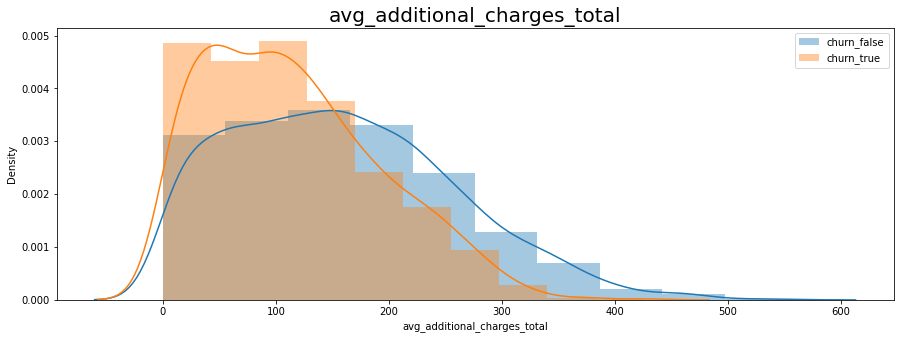

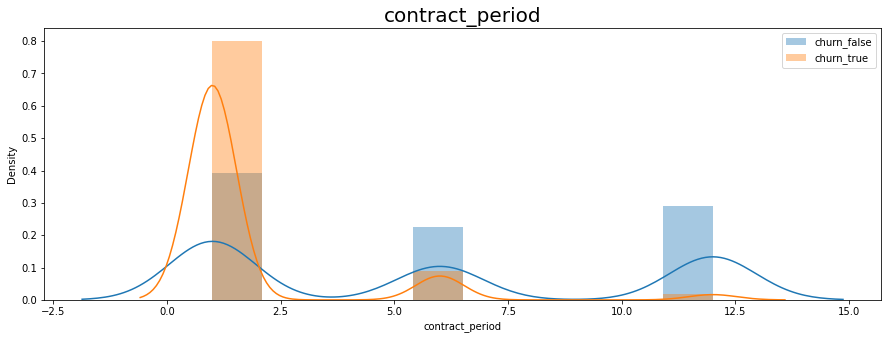

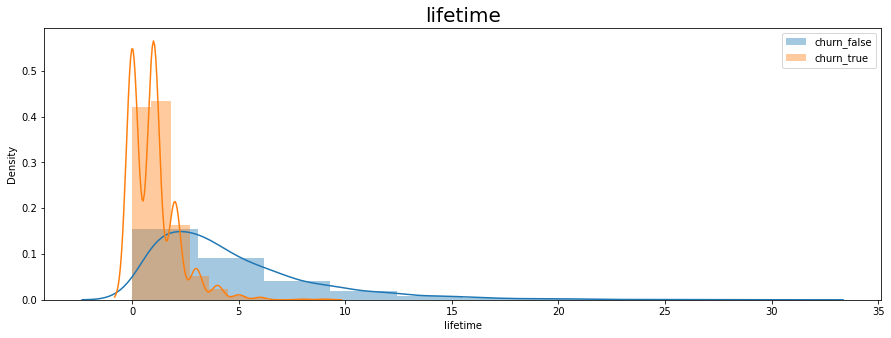

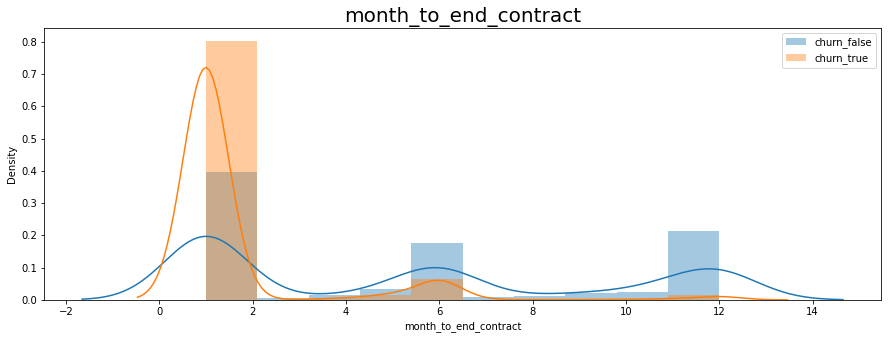

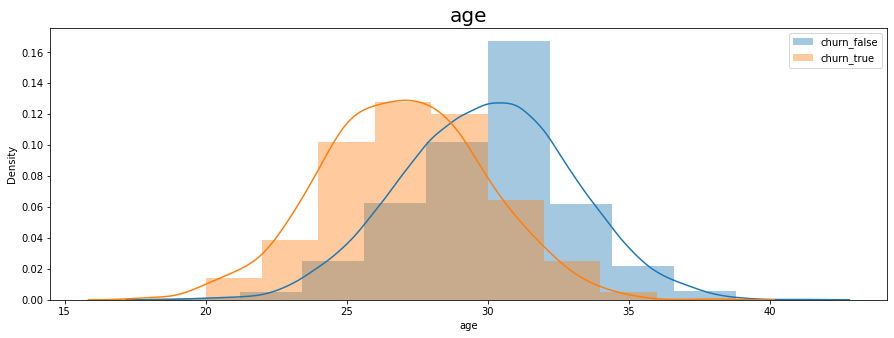

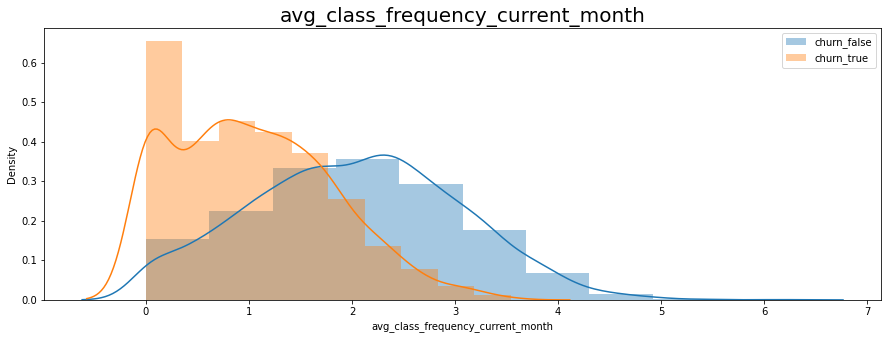

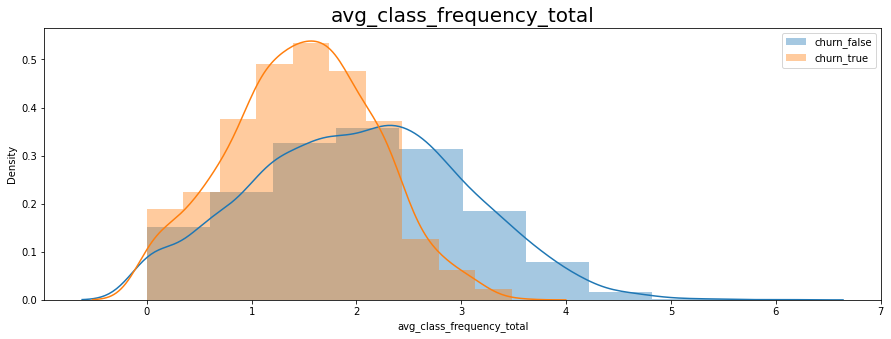

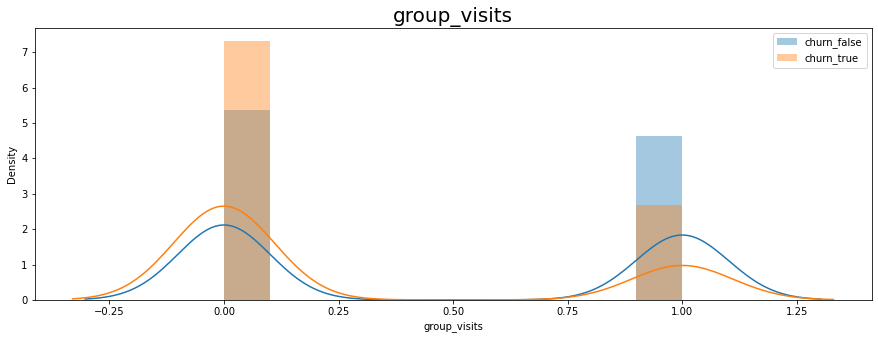

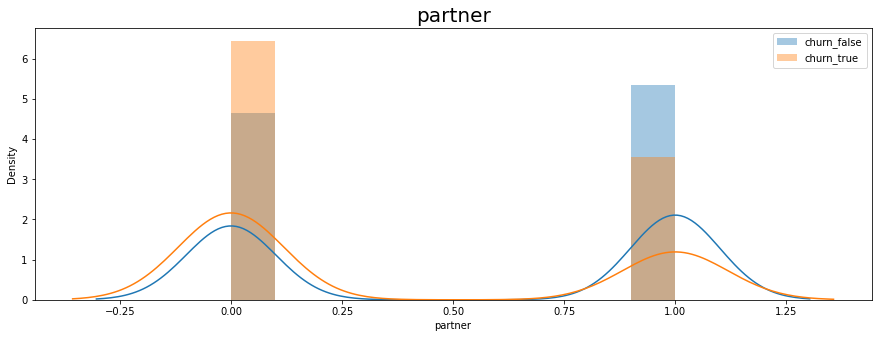

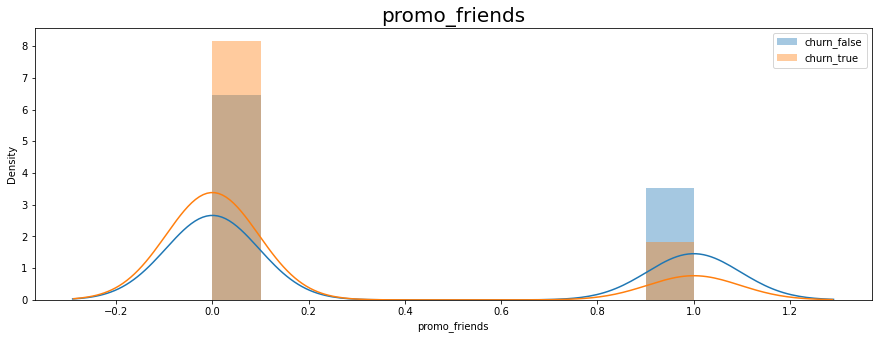

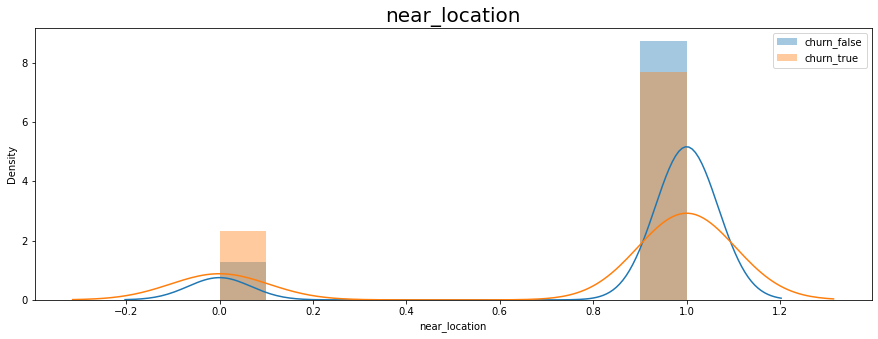

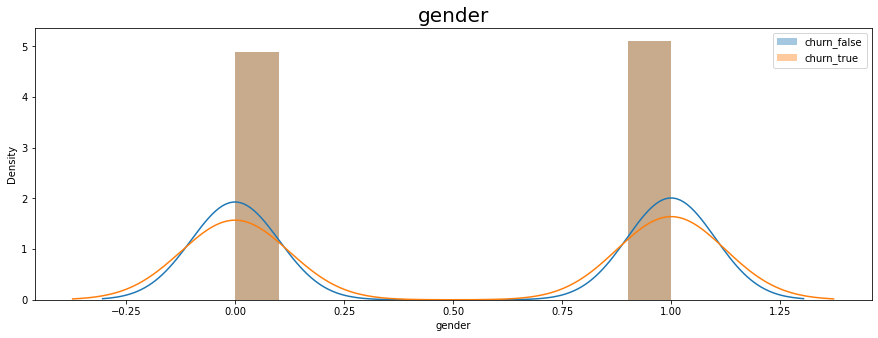

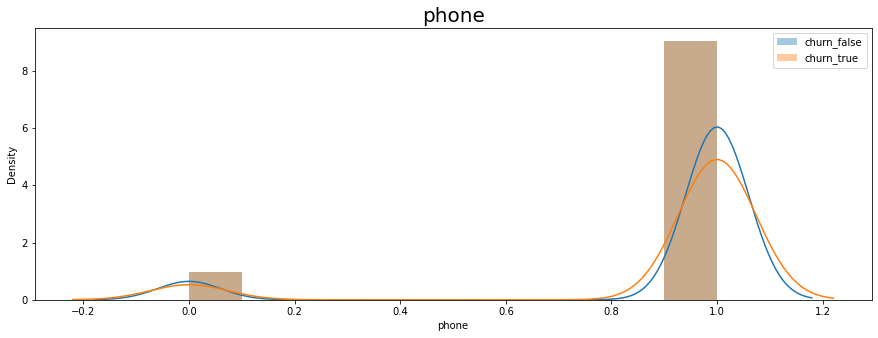

In [10]:
for i in churn_group.index:
    fig = plt.figure(figsize=(15,5))
    sns.distplot(df[df['churn']==0][i], bins=10, label='churn_false')
    sns.distplot(df[df['churn']==1][i], bins=10, label='churn_true')
    plt.legend()
    plt.title(i, fontsize=20)
    plt.show();

Краткие выводы по увиденному:
- `avg_additional_charges_total` - хм, получается достаточно интересно распределение. Пользователи которые ушли из клуба тратят меньше на сопутствующие услуги. Но при этом в диапазоне трат до 150 денег (так как валюта не известна, то буду измерять траты в «деньгах») таких пользователей больше. Иными словами - меньшие суммы они тратят чаще тех кто остался в клубе. 
- `contract_period` - похоже здесь есть какая-то закономерность. График позволяет предположить, что чем больше период абонемента, тем меньше пользователей уходят. 
- `lifetime` - похоже, что это дополнительный «взгляд» на предыдущий вывод. Чем меньше времени с первого обращения, тем больше посетителей уходит из клуба. 
- `month_to_end_contract` - история аналогичная двум предыдущим пунктам. 
- `age` - возраст в обоих группах имеет ярко выраженное нормальное распределение. Отличие тольк в смещении по оси `x` (возраст). Пользователи которые покидают клуб более молодые. Может быть они просто находятся в постоянном поиске? Или пользуются какими-то акциями для новых посетителей клуба (если такие есть) и экономят деньги на занятиях. 
- `avg_class_frequency_current_month` - интересно, что у оставшихся посетителей распределение частоты посещений нормальное. А вот у ушедших оно смещено в одну сторону. Очень заметно смещение (у ушедших) в сторону 0-1 посещения за предыдущий месяц.
- `avg_class_frequency_total` - подтверждение предыдущего вывода, но на другом масштабе посещений (по неделям). Большая часть ушедших пользователей не очень часто посещала еженедельные тренировки (1-2 раза).
- `group_visits` - хм, похоже, что среди ушедших пользователей доминируют интроверты ) Почему-то они не очень любят посещать групповые тренировки. 
- `partner` -  доля ушедших среди посетителей-партнеров заметно меньше, чем у посетителей-не партнеров. Может быть корпоративный дух положительно влияет на занятия спортом?)
- `promo_friends` - полные условия данной акции не известны, но скорее всего там были какие-то скидки/бонусы. График наглядно показывает разницу между тем кто пришел заниматься сам (по собственному желанию) и теми, кто воспользовался акцией от клуба. 
- `near_location` - доля отказников среди посетителей из соседних районов сильно выше, чем тех кто остался. Но в масштабах всех посетителей это не так важно. Так как всего посетителей из соседних районов только 15%
- `phone`, `gender` - по данным метрикам нет никаких видимых отличий. Думаю, что в дальнейшем анализе их можно будет не использовать. 

###  Постройте матрицу корреляций и отобразите её.

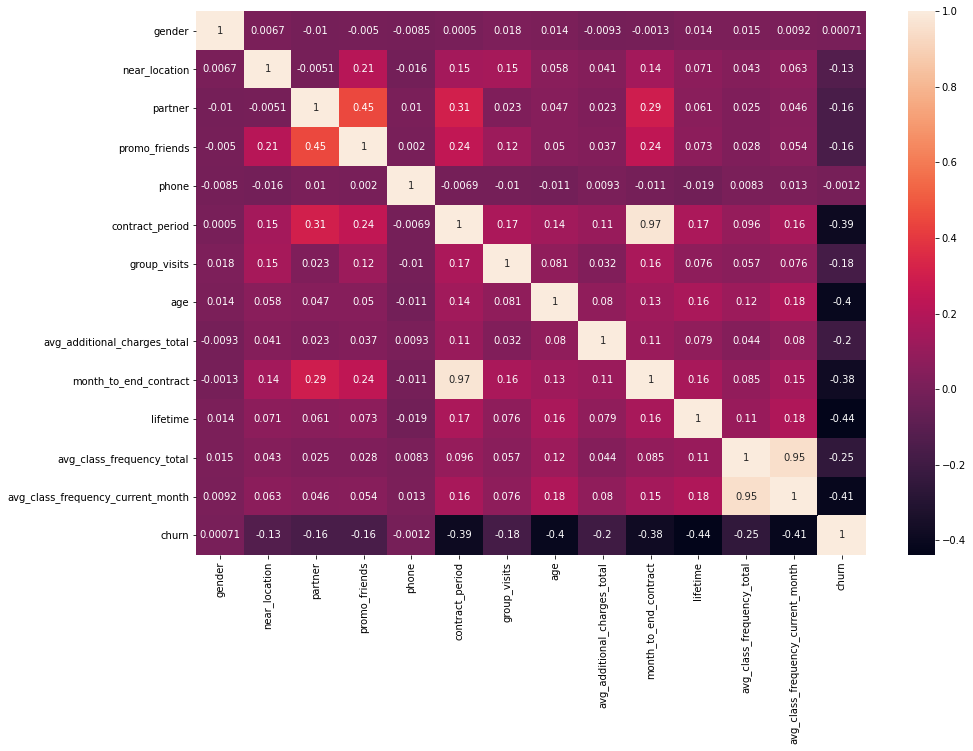

In [11]:
# матрица корреляций
cm = df.corr() 
fig, ax = plt.subplots(figsize=(15,10))

# тепловая карта
ax = sns.heatmap(cm, annot=True)
plt.show()

Ну здравствуй, мультиколлинеарность)
- `contract_period` и `month_to_end_contract` = 0.97
- `avg_class_frequency_total` и `avg_class_frequency_current_month` = 0.95

Думаю, что можно было и без матрицы корреляций понять о существований этих связей. Да и предыдущие графики уже давали подсказки) 

Так как наличие таких связей в данных может исказить все прогнозы и предсказания, то избавлюсь от некоторых метрик.

In [12]:
df_clear = df.drop(['contract_period', 'avg_class_frequency_current_month'], axis = 1) 

## 3. Модель прогнозирования оттока пользователей

Думаю, что прежде чем начинать обучать алгоритмы и делать какие-то выводы, стоит посмотреть __баланс классов__ по целевой переменной

In [13]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Очевидно, что о распределении 50/50 речи не идет. Будем об этом помнить )

In [14]:
#  разделим данные на признаки и целевую переменную.
X = df_clear.drop('churn', axis=1)
y = df_clear['churn']

In [15]:
# Чтобы сохранить возможность воспроизведения дальнейших расчетов использую фиксированный random_state
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [16]:
# Привожу данные к единому «масштабу». 
scaler = StandardScaler()

# Обучаю scaler и одновременно трансформирую матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)

In [17]:
# Применяю стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

Обучение моделей и вывод результатов оформлю через функцию. 

In [18]:
def make_prediction(model, X_train,y_train,X_test,y_test):
    result = {}
    model = model
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    result[model] = {'Accuracy':round(accuracy_score(y_test, predict),3),
                    'Precision':round(precision_score(y_test, predict),3),
                    'Recall':round(recall_score(y_test, predict),3)}
    print(result)

In [19]:
models = [LogisticRegression(random_state=42), RandomForestClassifier(random_state=42)]

for model in models:
    make_prediction(model, X_train_st, y_train, X_test_st, y_test)
    print('-'*100)

{LogisticRegression(random_state=42): {'Accuracy': 0.901, 'Precision': 0.806, 'Recall': 0.802}}
----------------------------------------------------------------------------------------------------
{RandomForestClassifier(random_state=42): {'Accuracy': 0.895, 'Precision': 0.814, 'Recall': 0.757}}
----------------------------------------------------------------------------------------------------


Итак, прежде чем подвести какие-то выводы и выбрать лучшую модель, позволю себе напомнить, что `Accuracy` - доля правильных ответов из всех прогнозов и очень чувствительная к __балансу классов__ и соотношению 50/50. А так как в нашем случае такой баланс классов не выдерживается, то получается (как я понял) данная метрика не может использоваться как честное сравнение эффективности разных моделей. 

Поэтому, для выбора лучшей модели остаются `Precision` и `Recall`. И если я все правильно понял из курса теории, то в данном сравнении нужно признать победителем `LogisticRegression`, так как полнота обнаружения реальных классов (recall) выше чем у `RandomForestClassifier`.

## 4. Кластеризация пользователей

Небольшая подготовка данных (убрать целевую метрику и нормализовать данные) и можно будте рисовать первую в жизни дендрограмму ) 

In [20]:
df_clear

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,1,29,14.227470,5.0,3,0.020398,0
1,0,1,0,0,1,1,31,113.202938,12.0,7,1.922936,0
2,0,1,1,0,1,0,28,129.448479,1.0,2,1.859098,0
3,0,1,1,1,1,1,33,62.669863,12.0,2,3.205633,0
4,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,0,33,2.406023,12.0,8,2.284497,0
3996,0,1,0,0,1,1,29,68.883764,1.0,1,1.277168,1
3997,1,1,1,1,1,0,28,78.250542,11.0,2,2.786146,0
3998,0,1,1,1,1,0,32,61.912657,5.0,3,1.630108,0


In [21]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler() 

# обучаем нормализатор и преобразуем набор данных
X_sc = scaler.fit_transform(df_clear.drop('churn', axis=1))

In [22]:
linked = linkage(X_sc, method='ward')

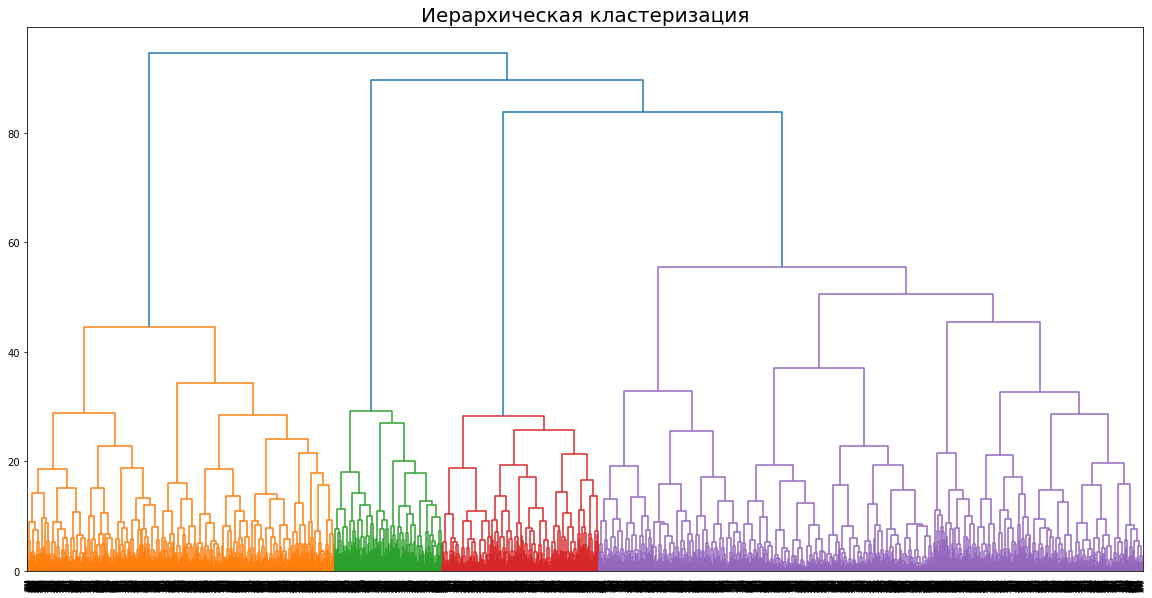

In [23]:
plt.figure(figsize=(20,10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=20)
plt.show();

Хоть далее по заданию и идет договоренность выделить пять кластеров, но у меня на графике почему-то прослеживается четкая разбивка на четыре кластера.
Теперь настала очередь попробовать и `K-means`. Так как на предыдущем шаге я уже подготовил данные (убрал `churn` и провел нормализацию), то использую эти данные и для данного алгоритма.

In [24]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state=42) 
# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_sc) 

In [25]:
# добавлю метки кластеров в DataFrame
df_clear['claster'] = labels

### Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?


In [26]:
df_clear.groupby('claster').mean().T

claster,0,1,2,3,4
gender,0.500000,0.505925,1.000000,0.523316,0.000000
near_location,0.000000,0.994531,1.000000,0.862694,1.000000
partner,0.487500,0.951686,0.209163,0.471503,0.249738
promo_friends,0.075000,0.860529,0.074701,0.305699,0.057712
phone,1.000000,1.000000,1.000000,0.000000,1.000000
group_visits,0.235714,0.516864,0.421315,0.427461,0.379853
age,28.719643,29.605287,29.085657,29.297927,29.030430
avg_additional_charges_total,137.701147,155.900765,143.467288,144.208179,146.834854
month_to_end_contract,2.837500,7.196901,2.984064,4.466321,3.239244
lifetime,3.057143,4.418414,3.481076,3.940415,3.487933


- `gender` - получилось два ярко выраженных противоположных кластера по полу. Один 100% мужской (кластер `2`), другой 100% женский (кластер `4`). В остальных кластерах распределение пола соответствует общей пропорции посетителей клуба 50/50
- `near_location` - кластер `0` на 100% состоит из жителей соседних районов. И это еще и второй по массовости кластер (840 человек). Остальные кластеры по большей части состоят из жителей района расположения клуба. 
- `partner` -не могу не отметить кластер `0`. 48% данного кластера это посетители по партнерской программе. Возможно они ходят в данный клуб только из-за спец.предложения от своего работодателя. 
- `promo_friends` - пожалуй здесь можно выделить кластер `1` как самый «дружелюбный». 86% посетителей пришли по приглашению друзей. 
- `phone` - считаю, что данная метрика не несет никакой полезной аналитики. Потому строить теории почему пользователи кластера `3` не оставляют свой номер телефона не буду. 
- `group_visits` - опять выделяется кластер `0`. Самая маленькая доля посещений групповых занятий (23%). Возможно, что данным посетителям не очень удобно добираться на групповые занятия? Им же приходится из других районов приезжать, вот они и не успевают 
- `age` - средний возраст всех кластеров крутится возле среднего возраста всех посетителей (29лет), так что здесь ничего удивительного нет.
- `avg_additional_charges_total` - трудно судить почему такой «странный» шаг в разбивке по дополнительным тратам, но цифры говорят, что кластер `0` тратит меньше всех
- `month_to_end_contract` - и опять кластер `0` показывает рекорд по минимальным значениям. Думаю, что здесь стоит изучать подробности партнерской программы. Не исключено, что данные посетители приходят только из-за желания работодателя, а не из-за любви к спорту. 
- `lifetime` -  аналогично предыдущему пункту 
- `avg_class_frequency_total` -  аналогично предыдущему пункту 
- `churn` - и здесь кластер `0` ставит рекорды. 40% пользователей покидают клуб. Возможно, что причина такого оттока прячется в двух факторах. Первый - люди живут в других районах. Второй - люди приходят в клуб из-за работодателя (партнерская программа).

In [27]:
df_clear.groupby('claster').agg({'churn':'mean'}).sort_values(by='churn')

,churn
claster,
1,0.116682
3,0.266839
4,0.303253
2,0.315737
0,0.400000


Тогда самым надежным кластером (минимум уходящих пользователей) будет `1`, а самым не надежным (максимум уходящих пользователей) будет `0`.

### Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?


Если я правильно все понял, то визуализировать надо не бинарные признаки. Так как в бинарных признаках только два значения ). Пока не уверен, что выбрал правильную визуализацию, но не хочется строить уйму графиков. Хочется на одной картинке все посмотреть. Поэтому и выбрал `pairplot`.

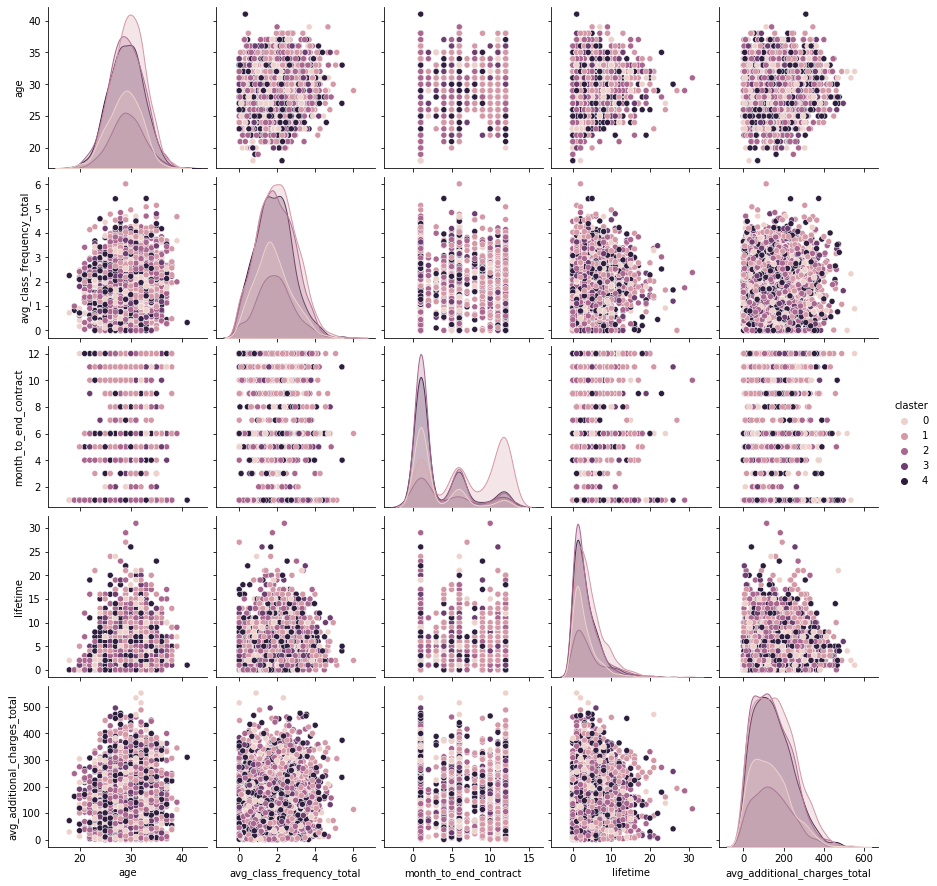

In [28]:
sns.pairplot(df_clear, vars=['age','avg_class_frequency_total','month_to_end_contract', 
                               'lifetime', 'avg_additional_charges_total'], hue='claster');

Честно говоря, трудно добавить что-то новое к предыдущим выводам. Либо я чего-то не вижу, либо я что-то сделал не так. 

### Для каждого полученного кластера посчитайте долю оттока (методом `groupby()`). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

Логика расчета будет такая:
- количество пользователей в каждом кластере - это количество любой метрики, например `age`. 
- количество пользователей которые ушли - это сумма метрики `churn`, так как те кто ушел имеют признак `1`, а те кто не ушел имеют признак `0`. Следовательно посчитав сумму получится количество ушедших в каждом кластере.

In [29]:
result = df_clear.groupby('claster').agg({'gender':'count', 'churn':'sum'})
result.columns = ['count_user', 'churn_true_count']
result['churn_true_share'] = result['churn_true_count']/result['count_user']
result.sort_values(by='churn_true_share')

,count_user,churn_true_count,churn_true_share
claster,,,
1,1097,128,0.116682
3,386,103,0.266839
4,953,289,0.303253
2,1004,317,0.315737
0,560,224,0.400000


Получается, что данными расчетами я лишь подтвердил сделаные ранее выводы по надежности кластеров. Либо я опять где-то ошибся, но надеюсь, что нет ) 

В таблице выше кластеры отсортированы в порядке убывания надежности пользователей. Получается, что кластер `0` самый ненадежный, так как 40% пользователей данного кластера уже покинули клуб. 

## 5. Выводы и рекомендации
Основной вывод - кластеры `0` и `2` являются лидерами по оттоку пользователей 40% и 31% соответственно. Считаю, что в первую очередь надо разобраться с оттоком именно по этим кластерам. В дальнейшем можно будет переходить к уменьшению оттока в остальных кластерах. 

Рекомендации по кластеру `0`:
- так как данный кластер на 100% состоит из пользователей «других» районов города, то скорее всего причину высокого оттока надо искать именно в этом. 
- возможно, что посетитиле просто вынуждены ходить в клуб, так как их работодатель является участником партнерской программы. Значит надо проверить условия данной программы и возможно как-то ее скорректировать.
- возможно, что посетителям просто не очень удобно попадать на групповые занятий (в среднем только 23% ходят на них) из-за логистических сложностей. Надо провести анализ времени посещения клуба и сопоставить его с расписанием групповых занятий. 
- возможно стоит внедрить отдельную программу `promo_friends` для жителей «других» районов. Если увеличить количество друзей в клубе, то возможно посетители будут чаще приходить на занятий, а значит будут оставаться в клубе дольше. 

Рекомендации по кластеру `2`:
- честно говоря, здесь не все так очевидно как в предыдущем случае, так как и групповые занятия есть (42%), и деньги тратят на сопутствующие услуги, и живут в районе с клубом. 
- предположу, что здесь надо работать с метриками `partner` и `promo_friends`. Возможно, что отток данного кластера удастся уменьшить если работодатель начнет компенсировать часть абонемента. Или, если в у данных посетителей будет больше друзей в данном клубе. Возможно они будут стимулировать друг-друга на более частые посещения и продления абонементов. 

Также хочу отметить, что в обоих кластерах (`0` и `2`) весьма схожи средние значения метрики `month_to_end_contract`. И там и там это порядка трех месяцев. Возможно, что данные посетители покупают абонемент на три месяца, а потом сталкиваются со всеми вышеперечисленными проблема и покидают клуб. В случае с партнерской программой - это опять вопрос к условиям программы. Может быть стоит увеличить срок абонемента в рамках данной программы? 